In [1]:
import toLog
log = toLog.log('Feature extraction starting')

In [2]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName('Python spark')
         .config('spark.some.config.option','some-value')
         .getOrCreate()
         )

In [3]:
# read file from hdfs and infer schema
df_cleaned = spark.read.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_cleaned.csv", header = True, inferSchema = True)
df_cleaned.printSchema()

root
 |-- id: long (nullable = true)
 |-- Hotel_Address: string (nullable = true)
 |-- Additional_Number_of_Scoring: integer (nullable = true)
 |-- Review_Date: string (nullable = true)
 |-- Average_Score: double (nullable = true)
 |-- Hotel_Name: string (nullable = true)
 |-- Reviewer_Nationality: string (nullable = true)
 |-- Review_Total_Negative_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews: integer (nullable = true)
 |-- Review_Total_Positive_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews_Reviewer_Has_Given: integer (nullable = true)
 |-- Reviewer_Score: double (nullable = true)
 |-- Tags: string (nullable = true)
 |-- days_since_review: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lng: string (nullable = true)
 |-- Review: string (nullable = true)
 |-- Hotel_Country: string (nullable = true)



In [3]:
df_cleaned.rdd.filter(lambda x: x['Review'] is None).count()

0

In [4]:
# register table (if not exists)
try:
    df_cleaned.createTempView('hotels')
except:
    pass

In [5]:
# selecting only the reviews using spark.sql
df_hotels = spark.sql("SELECT Hotel_Name, Review, lat, lng FROM hotels")
df_hotels.show()

+--------------------+--------------------+----------+----------+
|          Hotel_Name|              Review|       lat|       lng|
+--------------------+--------------------+----------+----------+
|         Hotel Arena|staff in restaura...|52.3605759| 4.9159683|
|         Hotel Arena|. overall hotel w...|52.3605759| 4.9159683|
|    K K Hotel George|no bad experience...|51.4918878|-0.1949706|
|    K K Hotel George|room is small any...|51.4918878|-0.1949706|
|Apex Temple Court...|my son and his fa...|51.5137335|-0.1087512|
|Apex Temple Court...|nothing to improv...|51.5137335|-0.1087512|
|Apex Temple Court...|my and my wife ca...|51.5137335|-0.1087512|
|Apex Temple Court...|expensive but thi...|51.5137335|-0.1087512|
|Apex Temple Court...|nothing not to li...|51.5137335|-0.1087512|
|Apex Temple Court...|. rooms are comfo...|51.5137335|-0.1087512|
|The Park Grand Lo...|socket for pluggi...|51.5142184|-0.1809032|
|The Park Grand Lo...|. staff very frie...|51.5142184|-0.1809032|
|The Park 

In [6]:
print(df_hotels.count())

504989


In [6]:
rddHotels = df_hotels.select('Hotel_Name', 'Review', 'lat', 'lng').rdd

# Features extraction

In [7]:
from getTriples import getTriples

In [8]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

In [9]:
def splitTriple(record):
    res = []
    for tripla in record[1]:
        res.append((record[0],tripla))
        
    return res

In [15]:
(rddHotels
 .map(lambda x: (x['Hotel_Name'], x['Review'] ))
 .map(lambda x: (x[0], getTriples(x[1])))
 .flatMap(splitTriple)).take(40)

[('Hotel Arena', ('building', 'very', 'historic')),
 ('Hotel Arena', ('hotel', '', 'overall')),
 ('Hotel Arena', ('work', '', 'complete')),
 ('K K Hotel George', ('experiences', '', 'bad')),
 ('K K Hotel George', ('nothing', '', 'wrong')),
 ('K K Hotel George', ('hotel', '', 'excellent')),
 ('K K Hotel George', ('room', 'very', 'comfortable')),
 ('K K Hotel George', ('size', '', 'good')),
 ('K K Hotel George', ('hotel', '', 'london')),
 ('K K Hotel George', ('tidy', '', 'clean')),
 ('K K Hotel George', ('staff', 'well', 'equipped')),
 ('K K Hotel George', ('class', '', 'first')),
 ('K K Hotel George', ('menu', '', 'comprehensive')),
 ('K K Hotel George', ('quality', '', 'good')),
 ('K K Hotel George', ('room', '', '')),
 ('K K Hotel George', ('anywaylondon', '', 'small')),
 ('Apex Temple Court Hotel', ('family', '', 'staying')),
 ('Apex Temple Court Hotel', ('rooms', '', 'identical')),
 ('Apex Temple Court Hotel', ('apex', 'directly', '')),
 ('Apex Temple Court Hotel', ('breakfasts', '

In [19]:
log.toLog('starting triples extraction')

In [38]:
SAMPLE_PERC = 0.001
df_features = (rddHotels
 #.sample(False, SAMPLE_PERC)
 .filter(lambda x: x['Review'] is not None)
 .map(lambda x: (x['Hotel_Name'], getTriples(x['Review'])))
 .flatMap(splitTriple)
 .map(lambda x:( x[0], x[1][0], (vader.polarity_scores(" ".join(x[1]))['compound']+1)*5) )
              ).toDF(["hotel", "feature", "scores"])

In [39]:
# register table (if not exists)
try:
    df_features.createTempView('features')
except:
    spark.catalog.dropTempView('features')
    df_features.createTempView('features')

In [40]:
spark.sql("SELECT hotel, feature, scores from features order by scores ").show()

+--------------------+----------+------------------+
|               hotel|   feature|            scores|
+--------------------+----------+------------------+
|Hilton London Wem...|     dirty|             1.408|
|Grange St Paul s ...|   flowers|1.7570000000000001|
|Grange St Paul s ...|   flowers|1.7570000000000001|
|The Royal Park Hotel|      room|1.7570000000000001|
|The Royal Park Hotel|      till|1.7570000000000001|
|Park Grand Paddin...|       ham|            1.8755|
|Catalonia Eixampl...|      view|            1.8755|
|    Catalonia Atenas|    racist|1.9379999999999997|
| Strand Palace Hotel|     items|1.9379999999999997|
|    Silken Concordia|experience|2.1405000000000003|
|Great Northern Ho...|     smell|            2.2885|
|AC Hotel Diagonal...|      food|            2.2885|
|Holiday Inn Paris...|  horrible|            2.2885|
|Fleming s Selecti...|     smell|            2.2885|
|Hampshire Hotel R...|     smell|            2.2885|
|The Nadler Kensin...|  mattress|             

In [41]:
spark.sql("SELECT hotel, feature, \
AVG(scores) as avg_scores, COUNT(scores) as n_scores \
FROM features GROUP BY hotel, feature \
ORDER BY hotel, avg_scores  ").show(40)

+--------------------+------------+------------------+--------+
|               hotel|     feature|        avg_scores|n_scores|
+--------------------+------------+------------------+--------+
|          88 Studios|   furniture|               5.0|       1|
|          88 Studios|    location|            8.1245|       1|
|AC Hotel Diagonal...|        food|            2.2885|       1|
|AC Hotel Paris Po...|       sites|               5.0|       1|
|AC Hotel Paris Po...|     station|               5.0|       1|
|AC Hotel Paris Po...|       staff| 7.377000000000001|       1|
|         Acta CITY47|surroundings|               5.0|       1|
|         Acta CITY47|        park|               5.0|       1|
|         Acta CITY47|    bathroom| 7.997000000000001|       1|
|  Aloft London Excel|        door|               5.0|       1|
|  Aloft London Excel|  assistance|               5.0|       1|
|  Aloft London Excel|     process|               5.0|       1|
|  Aloft London Excel|         bed|     

In [42]:
df_features.count()

1904

In [43]:
import json
# reading the defined categories
with open('final_categories.json') as f:
     categories = json.load(f)

In [44]:
categories

{'bathroom': ['washbasin',
  'restroom',
  'cubicle',
  'bathrooms',
  'ensuite',
  'fixture',
  'bathroom.',
  'toilette',
  'washroom',
  'toilet',
  'bath',
  'shower',
  'bathtub',
  'towels',
  'showerhead',
  'wc'],
 'facilities': ['bar',
  'supplies',
  'facility.',
  'equipment',
  'furniture',
  'ammenities',
  'lift',
  'facilities.',
  'tv',
  'facility',
  'facilties',
  'facilites',
  'spa.',
  'amenities',
  'massages',
  'equipments',
  'pool'],
 'food': ['breakfest',
  'grill',
  'restaurants',
  'menu.',
  'breakfeast',
  'food.',
  'food',
  'resturant',
  'selections',
  'coffee',
  'resteraunt',
  'seafood',
  'menu',
  'sushi',
  'bfast',
  'brekkie',
  'tea',
  'dinner.',
  'breakfast',
  'carvery',
  'foods',
  'breakfast.',
  'bistro',
  'breakfasts',
  'menus',
  'breafast',
  'brekfast',
  'buffet',
  'meals',
  'presentation',
  'beakfast',
  'brakfast',
  'brasserie',
  'drinks',
  'breackfast',
  'steak',
  'assortment',
  'wines'],
 'internet': ['4g',
  'w

In [45]:
def assign_categories(feat):
    'assign category to each feature'
    for cat,dict_feat in categories.items():
        if feat == cat or feat in dict_feat  :
            return cat
    
    return 'other'
    

In [46]:
df_features = (df_features.rdd
                 .map(lambda x: (x['hotel'],x['feature'],assign_categories(x['feature']), x['scores'] ))
                 .toDF(['hotel', 'feature', 'categories', 'score'])
                )

In [47]:
df_features.head(20)

[Row(hotel='St Paul s Hotel', feature='staff', categories='staff', score=7.1075),
 Row(hotel='St Paul s Hotel', feature='room', categories='room', score=5.0),
 Row(hotel='St Paul s Hotel', feature='bed', categories='room', score=7.553000000000001),
 Row(hotel='St Paul s Hotel', feature='breakfast', categories='food', score=7.202),
 Row(hotel='Millennium Gloucester Hotel London', feature='room', categories='room', score=5.0),
 Row(hotel='Millennium Gloucester Hotel London', feature='draught', categories='other', score=5.0),
 Row(hotel='Millennium Gloucester Hotel London', feature='winter', categories='other', score=3.2940000000000005),
 Row(hotel='Millennium Gloucester Hotel London', feature='room', categories='room', score=5.0),
 Row(hotel='Millennium Gloucester Hotel London', feature='safe', categories='other', score=7.202),
 Row(hotel='Millennium Gloucester Hotel London', feature='breakfast', categories='food', score=5.0),
 Row(hotel='Millennium Gloucester Hotel London', feature='tim

In [ ]:
df_features.write.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_features.csv", header = True)

# Features cleaning

In [3]:
df_features = spark.read.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_features.csv", header = True, inferSchema = True)

In [4]:
df_features.printSchema()


root
 |-- hotel: string (nullable = true)
 |-- feature: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- score: double (nullable = true)



In [5]:
df_features.count()

1984996

In [6]:
try:
    df_features.createTempView('df_features')
except:
    spark.catalog.dropTempView('df_features')
    df_features.createTempView('df_features')

In [7]:
#remove all features with neutral score
df_features_temp = spark.sql("SELECT * FROM df_features WHERE score != 5.0 and categories != 'other'")

In [8]:
try:
    df_features_temp.createTempView('temp')
except:
    spark.catalog.dropTempView('temp')
    df_features_temp.createTempView('temp')

In [12]:
spark.sql("SELECT hotel, count(categories) as conto FROM temp WHERE categories != 'other' GROUP BY hotel having conto > 600  order by conto DESC ").show()

+--------------------+-----+
|               hotel|conto|
+--------------------+-----+
|Park Plaza Westmi...| 4141|
| Strand Palace Hotel| 3827|
|Britannia Interna...| 3662|
|Copthorne Tara Ho...| 3259|
|DoubleTree by Hil...| 3233|
|Intercontinental ...| 2631|
|Grand Royale Lond...| 2627|
|Holiday Inn Londo...| 2584|
|Millennium Glouce...| 2324|
|Park Plaza County...| 2229|
|Park Grand Paddin...| 2218|
|Hilton London Met...| 2211|
|DoubleTree by Hil...| 2204|
|Park Grand London...| 2196|
|      Hotel Esther a| 2182|
| Blakemore Hyde Park| 2168|
|Hilton London Wem...| 2060|
|Park Plaza London...| 2019|
|St James Court A ...| 1991|
|The Tower A Guoma...| 1891|
+--------------------+-----+
only showing top 20 rows



In [9]:
df_features_cleaned = spark.sql("SELECT hotel, categories, feature, score, count(categories) over(partition by(hotel) order by score) as conto, hotel FROM temp WHERE categories != 'other' ORDER BY conto DESC").filter('conto > 70')

In [10]:
df_features_cleaned.show(10)

+--------------------+----------+--------+-----------------+-----+--------------------+
|               hotel|categories| feature|            score|conto|               hotel|
+--------------------+----------+--------+-----------------+-----+--------------------+
|Park Plaza Westmi...|  location|   views|            9.195| 4141|Park Plaza Westmi...|
|Park Plaza Westmi...|     staff|   staff|           9.1835| 4140|Park Plaza Westmi...|
|Park Plaza Westmi...|  location|   views|            9.158| 4139|Park Plaza Westmi...|
|Park Plaza Westmi...|      room|    room|           9.1355| 4138|Park Plaza Westmi...|
|Park Plaza Westmi...|     staff|   staff|9.129000000000001| 4137|Park Plaza Westmi...|
|Park Plaza Westmi...|      room|    room|           9.1125| 4136|Park Plaza Westmi...|
|Park Plaza Westmi...|  location|   views|           9.1055| 4135|Park Plaza Westmi...|
|Park Plaza Westmi...|  location|   views|            9.081| 4134|Park Plaza Westmi...|
|Park Plaza Westmi...|  location

In [11]:
df_features_cleaned.count()

438259

In [43]:
pdf_features = df_features_cleaned.sample(False, 0.1).toPandas()

In [44]:
dist_categ = pdf_features.groupby('categories').count().feature

In [45]:
###########################################################
import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y label
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

###########################################################


In [46]:
dist_categ.index

Index(['bathroom', 'facilities', 'food', 'internet', 'location', 'room',
       'staff'],
      dtype='object', name='categories')

In [47]:
tot = dist_categ.sum()
tot

43667

[Text(0,0,'bathroom'),
 Text(0,0,'facilities'),
 Text(0,0,'food'),
 Text(0,0,'internet'),
 Text(0,0,'location'),
 Text(0,0,'room'),
 Text(0,0,'staff')]

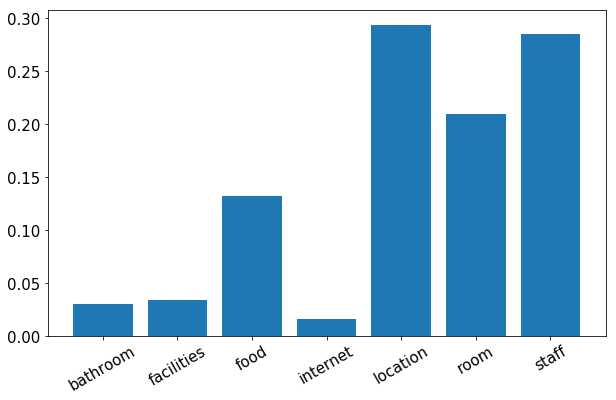

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(dist_categ.index, dist_categ/tot)
ax.set_xticklabels(dist_categ.index, rotation = 30)

scalo lo score dall'intervallo [0-10] in [2-10]

In [13]:
df_features_cleaned_scaled = spark.sql("SELECT hotel, categories, feature, score*8/10+2 as score, count(categories) over(partition by(hotel) order by score) as conto, hotel FROM temp WHERE categories != 'other' ORDER BY conto DESC").filter('conto > 70')

In [16]:
df_features_cleaned_scaled.show(10)

+--------------------+----------+--------+-----------------+-----+--------------------+
|               hotel|categories| feature|            score|conto|               hotel|
+--------------------+----------+--------+-----------------+-----+--------------------+
|Park Plaza Westmi...|  location|   views|            9.356| 4141|Park Plaza Westmi...|
|Park Plaza Westmi...|     staff|   staff|           9.3468| 4140|Park Plaza Westmi...|
|Park Plaza Westmi...|  location|   views|           9.3264| 4139|Park Plaza Westmi...|
|Park Plaza Westmi...|      room|    room|           9.3084| 4138|Park Plaza Westmi...|
|Park Plaza Westmi...|     staff|   staff|           9.3032| 4137|Park Plaza Westmi...|
|Park Plaza Westmi...|      room|    room|9.290000000000001| 4136|Park Plaza Westmi...|
|Park Plaza Westmi...|  location|   views|           9.2844| 4135|Park Plaza Westmi...|
|Park Plaza Westmi...|  location|   views|           9.2648| 4134|Park Plaza Westmi...|
|Park Plaza Westmi...|  location

In [17]:
# register table 
try:
    df_features_cleaned_scaled.createTempView('categories')
except:
    spark.catalog.dropTempView('categories')
    df_features_cleaned_scaled.createTempView('categories')

In [18]:
spark.sql("SELECT hotel, categories, feature, score from categories").show()

+--------------------+----------+----------+-----------------+
|               hotel|categories|   feature|            score|
+--------------------+----------+----------+-----------------+
|Park Plaza Westmi...|  location|     views|            9.356|
|Park Plaza Westmi...|     staff|     staff|           9.3468|
|Park Plaza Westmi...|  location|     views|           9.3264|
|Park Plaza Westmi...|      room|      room|           9.3084|
|Park Plaza Westmi...|     staff|     staff|           9.3032|
|Park Plaza Westmi...|      room|      room|9.290000000000001|
|Park Plaza Westmi...|  location|     views|           9.2844|
|Park Plaza Westmi...|  location|     views|           9.2648|
|Park Plaza Westmi...|  location|  location|           9.2296|
|Park Plaza Westmi...|  location|     views|           9.2296|
|Park Plaza Westmi...|     staff|     staff|           9.2296|
|Park Plaza Westmi...|      room|      room|9.185599999999999|
|Park Plaza Westmi...|      room|      room|9.185599999

In [19]:
spark.sql("SELECT hotel, categories, AVG(score) as avg_scores, COUNT(score) as n_scores \
FROM categories GROUP BY hotel, categories ORDER BY hotel, avg_scores  ").show()

+--------------------+----------+-----------------+--------+
|               hotel|categories|       avg_scores|n_scores|
+--------------------+----------+-----------------+--------+
|  11 Cadogan Gardens|facilities|8.226666666666667|       3|
|  11 Cadogan Gardens|      food|8.286742857142857|       7|
|  11 Cadogan Gardens|      room|8.287013333333332|      15|
|  11 Cadogan Gardens|  location|          8.37905|      24|
|  11 Cadogan Gardens|  bathroom|          8.38192|       5|
|  11 Cadogan Gardens|     staff|        8.4108625|      32|
|            1K Hotel|      food|7.932000000000001|      11|
|            1K Hotel|  bathroom|8.030533333333333|       3|
|            1K Hotel|  internet|           8.0424|       1|
|            1K Hotel|     staff|          8.06048|      25|
|            1K Hotel|      room|8.160673684210527|      19|
|            1K Hotel|  location|8.232766666666665|      36|
|            1K Hotel|facilities|8.440199999999999|       4|
|25hours Hotel bei...|fa

# Export final dataframe

In [ ]:
log.toLog('start group by hotel/categories')

In [20]:
import pyspark.sql.functions as func

In [21]:
df_final = df_features_cleaned.groupBy("hotel").pivot('categories').agg(func.avg('score'))

In [22]:
df_final.write.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_categories_scaled.csv", header = True)

In [ ]:
log.toLog('end feature extraction')
log.close()